# 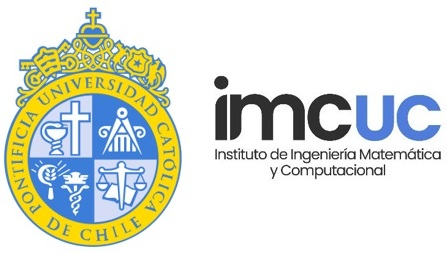  IMT 2200 - Introducción a Ciencia de Datos
**Pontificia Universidad Católica de Chile**<br>
**Instituto de Ingeniería Matemática y Computacional**<br>
**Semestre 2023-2**<br>
**Profesor:** Rodrigo A. Carrasco <br>
---

# <h1><center>Clase 22: Aprendizaje Supervisado: Regresiones</center></h1>

En este notebook aplicaremos las herramientas implementadas en las librerías de Python `statsmodels` y `scipy` para realizar regresiones.

Para implementar regresiones lineales y predecir los outcomes para distintas variables de entrada, podemos usar distintas librerías de `python`:

* [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html).
* [statsmodels](http://www.statsmodels.org/stable/regression.html) y 
* [scikit-learn (sklearn)](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).


Para efectos de regresiones lineales simples,`scipy`, `statsmodels` y `sklearn` hacen lo mismo. Más en general,  `statsmodels` tiende a ser más fácil para problemas de inferencia (econtrar los parámetros de la regresión y analizar sus incertezas) mientras que  `sklearn` tiene un enfoque de machine learning y es más práctico para realizar predicciones.

## Caso de Estudio: rendimiento de algunos autos


### Descripción del Dataset

Para este ejercicio, tenemos como ejemplo un dataset con datos de automóviles, extraidos del repositorio UCI Machine Learning Repository:

https://archive.ics.uci.edu/ml/datasets/auto+mpg


*The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)* <br>

Los datos incluyen datos sobre características del diseño e ingeniería de distintos modelos de autos, como se describe a continuación:

- `mpg`: rendimiento de combustible en millas/galón. 
- `cylinders`: número de cilindros. is Number of cylinders, 
- `displacement`: desplazamiento (cu.in.), 
- `horsepower`: potencia en "caballos de fuerza". 
- `weight`: peso (en miles de libras).
- `acceleration`: tiempo en recorrer 1/4 de milla desde el reposo.
- `origin`: origen 
- `car name`: nombre del modelo 

### Objetivo

El objetivo es predecir el consumo de un vehículo, en función de sus parámetros de diseño e ingeniería.

## 1. Datos a analizar

El archivo `auto-mpg.csv` será la base que usaremos para este trabajo.

In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
%matplotlib inline

## 2. EDA

### 2.1 Exploración inicial

Exploremos primero un poco los datos para entender qué relaciones podrían existir.

In [2]:
dfautos = pd.read_csv("auto-mpg.csv")
dfautos.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
dfautos.dropna(axis=0, inplace=True)
dfautos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [4]:
dfautos['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [5]:
dfautos = dfautos[dfautos['horsepower']!='?']

In [6]:
dfautos['origin'] = dfautos['origin'].astype('category')
dfautos['car name'] = dfautos['car name'].astype('category')
dfautos['cylinders'] = dfautos['cylinders'].astype('category')
dfautos['horsepower'] = dfautos['horsepower'].astype('float')

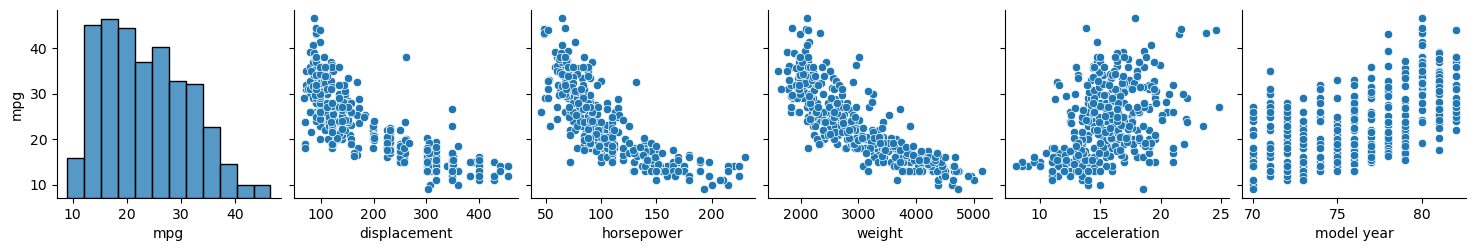

In [7]:
# explorar datos
sns.pairplot(dfautos, y_vars='mpg')

<Axes: >

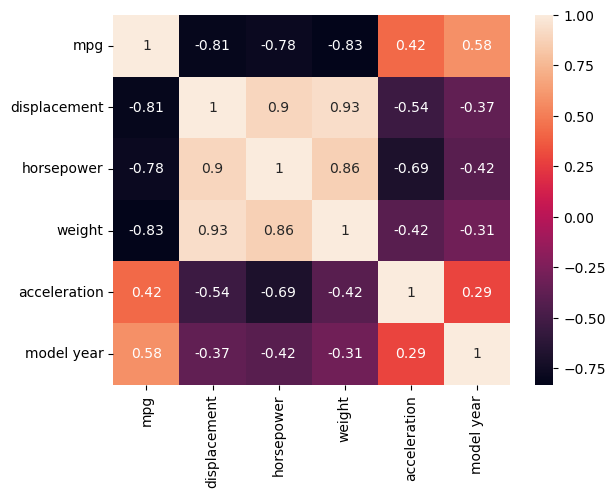

In [8]:
sns.heatmap(dfautos.corr(numeric_only=True), annot=True)

### 2.2 Rendimiento según diferentes dimensiones

Exploremos cuál es el rendimiento promedio para distintas combinaciones de cilindros y hp.

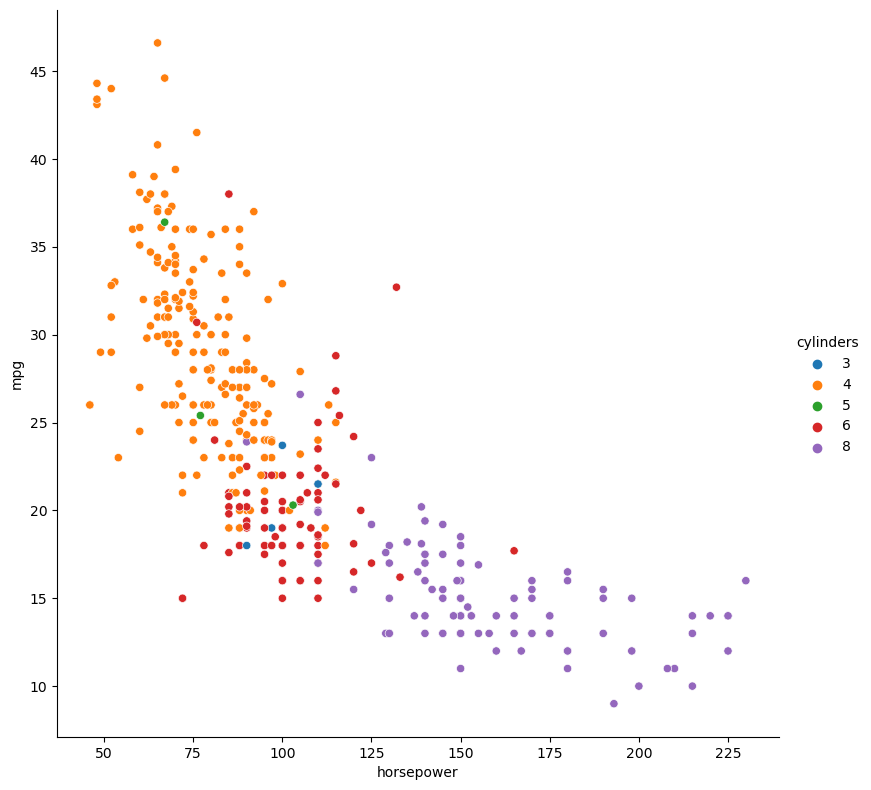

In [9]:
sns.pairplot(data=dfautos, y_vars='mpg', x_vars='horsepower', hue='cylinders', height=8)

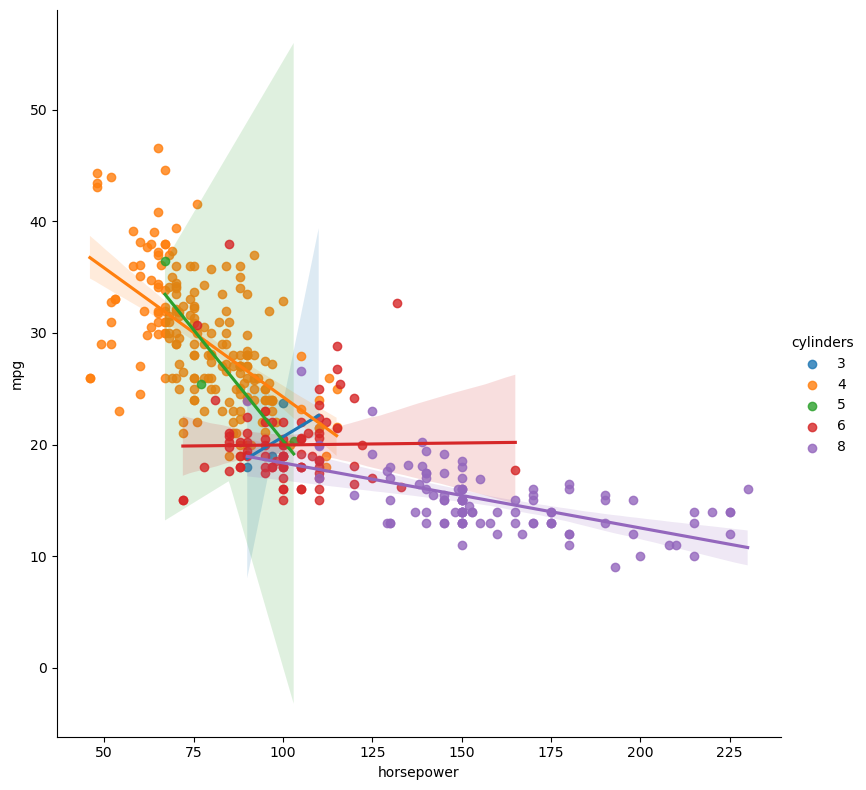

In [10]:
sns.lmplot(data=dfautos, y='mpg', x='horsepower', hue='cylinders', height=8)

## 3. Regresión Lineal

### 3.1 Armando el modelo

- Nota sobre constantes:

Supongamos un caso sencillo, en que tenemos 2 observaciones con un predictor y una variable de respuesta cada una. Tendríamos por lo tanto el siguiente sistema de ecuaciones para el modelo de regresión lineal simple:
 $$y_1=\beta_0 + \beta_1\cdot x_1$$ $$y_2=\beta_0 + \beta_1\cdot x_2$$ <BR>
    
En notación matricial, esto sería: 
    
$$
\left [
\begin{array}{c}
y_1 \\ y_2 \\
\end{array}
\right] =
\left [
\begin{array}{cc}
1& x_1 \\ 1 & x_2 \\
\end{array}
\right] 
\cdot
\left [
\begin{array}{c}
\beta_0 \\ \beta_1 \\
\end{array}
\right]
$$
<BR><BR>
    
`sklearn` agrega automáticamente la constante `1`, mientras que en  `statsmodels` hay que agregarla explícitamente usando `sm.add_constant`

In [11]:
import statsmodels.api as sm

x = np.array(dfautos.horsepower)
y = np.array(dfautos.mpg)

In [12]:
X = sm.add_constant(x)
X

array([[  1., 130.],
       [  1., 165.],
       [  1., 150.],
       [  1., 150.],
       [  1., 140.],
       [  1., 198.],
       [  1., 220.],
       [  1., 215.],
       [  1., 225.],
       [  1., 190.],
       [  1., 170.],
       [  1., 160.],
       [  1., 150.],
       [  1., 225.],
       [  1.,  95.],
       [  1.,  95.],
       [  1.,  97.],
       [  1.,  85.],
       [  1.,  88.],
       [  1.,  46.],
       [  1.,  87.],
       [  1.,  90.],
       [  1.,  95.],
       [  1., 113.],
       [  1.,  90.],
       [  1., 215.],
       [  1., 200.],
       [  1., 210.],
       [  1., 193.],
       [  1.,  88.],
       [  1.,  90.],
       [  1.,  95.],
       [  1., 100.],
       [  1., 105.],
       [  1., 100.],
       [  1.,  88.],
       [  1., 100.],
       [  1., 165.],
       [  1., 175.],
       [  1., 153.],
       [  1., 150.],
       [  1., 180.],
       [  1., 170.],
       [  1., 175.],
       [  1., 110.],
       [  1.,  72.],
       [  1., 100.],
       [  1.,

In [13]:
# modelo OLS (ordinary least squares) entrenado con los datos
regr_sm = sm.OLS(y, X)

# aplicar fit para entrenar y guardar el modelo
results_sm = regr_sm.fit()

# entregar informacion general del modelo
results_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 01 Nov 2023   Prob (F-statistic):           7.03e-81
Time:                        19:09:23   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
x1            -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# cpeficientes beta
beta0 = results_sm.params[0]
beta1 = results_sm.params[1]
beta0, beta1

(39.935861021170474, -0.15784473335365357)

### 3.2 Visualizando datos y predicciones

Ahora queremos ver los datos junto a las predicciones hachas por el modelo

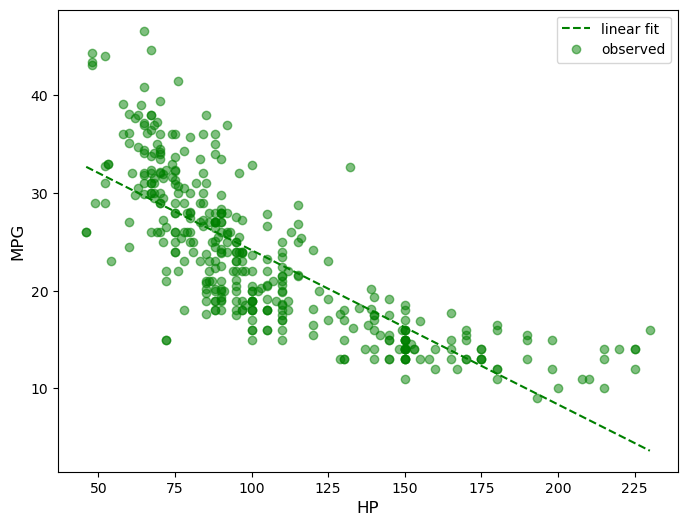

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

grid = np.linspace(np.min(dfautos.horsepower), np.max(dfautos.horsepower), 100)

y_fit = beta0 + beta1*grid

ax.plot(grid, y_fit, '--', color='g', label='linear fit')
ax.plot(dfautos.horsepower, dfautos.mpg, 'o', color='g', alpha=0.5, label='observed') 
ax.set_xlabel("HP", fontsize=12)
ax.set_ylabel("MPG", fontsize=12)
ax.legend();

Veamos ahora para el peso en `weight`.

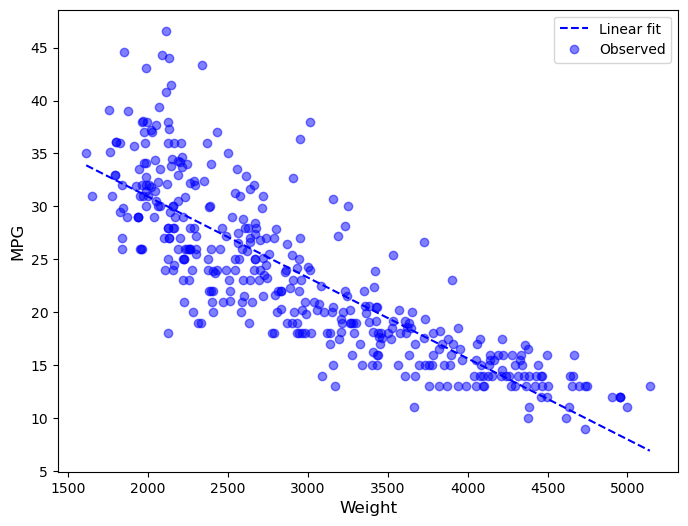

In [16]:
# preparar datos
x = np.array(dfautos.weight)
y = np.array(dfautos.mpg)
X = sm.add_constant(x)

# realizar modelo
regr_sm = sm.OLS(y, X)
results_sm = regr_sm.fit()

# extraer par'ametros
beta0 = results_sm.params[0]
beta1 = results_sm.params[1]

# visualizar
fig, ax = plt.subplots(1,1, figsize=(8,6))
grid = np.linspace(np.min(dfautos.weight), np.max(dfautos.weight), 100)
y_fit_lineal = beta0 + beta1*grid

ax.plot(grid, y_fit_lineal, '--', color='b', label='Linear fit')
ax.plot(dfautos.weight, dfautos.mpg, 'o', color='b', alpha=0.5, label='Observed') 

ax.set_xlabel("Weight", fontsize=12)
ax.set_ylabel("MPG", fontsize=12)
ax.legend()

In [17]:
results_sm.rsquared

0.6926304331206254

### 3.3 Regresión  Polinomial

En una regresión polinomial, usamos un **modelo lineal** para estimar una **función no lineal** (i.e., una función con términos polinomiales). Por ejemplo, 

$y = \beta_0 + \beta_1x_i + \beta_2x_i^{2}$

Es un modelo _lineal_ porque resolvemos una ecuación lineal para obtener los coeficientes $\beta$.

In [18]:
import statsmodels.formula.api as smf

#¿Es un buen ajuste? tal vez podemos probar con una funcion no lineal
dfautos['wt2'] = dfautos['weight']**2

# Calcular regresión lineal con 
lm1 = smf.ols('mpg ~ weight + wt2', data=dfautos).fit()

# Print the estimated parameters
print(lm1.params, lm1.rsquared)
lm1.summary()

Intercept    62.255474
weight       -0.018496
wt2           0.000002
dtype: float64 0.7151475557845138


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     488.3
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          8.39e-107
Time:                        19:09:24   Log-Likelihood:                -1115.1
No. Observations:                 392   AIC:                             2236.
Df Residuals:                     389   BIC:                             2248.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.2555      2.993     20.800      0.000      56.371      68.140
weight        -0.0185      0.002     -9.379      0.000      -0.022      -0.015
wt2         1.697e-06   3.06e-07      5.545      0.000     1.1e-06     2.3e-06
==============================================================================
Omnibus:                       53.804   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.923
Skew:                           0.809   Prob(JB):                     4.03e-21
Kurtosis:                       4.770   Cond. No.                     1.57e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

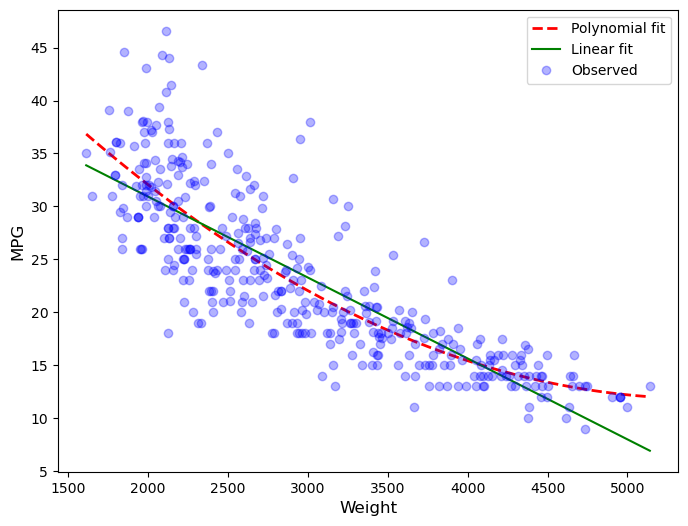

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

xgrid = np.linspace(np.min(dfautos.weight), np.max(dfautos.weight), 100)

y_fit_poly = lm1.params[0] + lm1.params[1]*xgrid + lm1.params[2]*xgrid**2

ax.plot(xgrid, y_fit_poly, '--', color='r', label='Polynomial fit', lw=2)
ax.plot(grid, y_fit_lineal, '-', color='green', label='Linear fit')

ax.plot(dfautos.weight, dfautos.mpg, 'o', color='b', alpha=0.3, label='Observed') 

ax.set_xlabel("Weight", fontsize=12)
ax.set_ylabel("MPG", fontsize=12)
ax.legend()

In [20]:
from sklearn.metrics import mean_squared_error

y_predict_lin = beta0 + beta1*x
print('MSE lineal:', mean_squared_error(y, y_predict_lin))


y_predict_poly = lm1.params[0] + lm1.params[1]*x + lm1.params[2]*x**2
print('MSE poly:', mean_squared_error(y, y_predict_poly))

MSE lineal: 18.6766165974193
MSE poly: 17.308414562519907


## 4. Regresión Multilineal

### 4.1 Armando el modelo

Supongamos ahora un modelo incluyendo múltiples variables:

$$\text{mpg} \approx \beta_0 + \beta_1\text{disp} + \beta_2\text{hp} + \beta_3\text{wt} +\beta_4\text{wt}^2 $$

In [21]:
import statsmodels.formula.api as smf

def build_xmatrix(df, columns, cols_squared=[]):
    x_matrix = df[columns].copy()
    
    for col in cols_squared:
        x_matrix['%s_2'%col] = df[col]**2
    
    x_matrix = sm.add_constant(x_matrix)
    return(x_matrix)

In [22]:
columns = ['displacement','horsepower','weight']
cols_squared = ['weight']

x_matrix = build_xmatrix(dfautos, columns, cols_squared)
x_matrix.head()

,const,displacement,horsepower,weight,weight_2
0,1.0,307.0,130.0,3504,12278016
1,1.0,350.0,165.0,3693,13638249
2,1.0,318.0,150.0,3436,11806096
3,1.0,304.0,150.0,3433,11785489
4,1.0,302.0,140.0,3449,11895601


In [23]:
import statsmodels.api as sm
from statsmodels.api import OLS

y = dfautos.mpg
fitted_model = OLS(y, x_matrix, hasconst=True).fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     271.9
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          5.39e-111
Time:                        19:09:25   Log-Likelihood:                -1099.0
No. Observations:                 392   AIC:                             2208.
Df Residuals:                     387   BIC:                             2228.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           63.9161      3.054     20.929      0.000      57.912      69.920
displacement    -0.0046      0.006     -0.732      0.465      -0.017       0.008
horsepower      -0.0566      0.012     -4.583      0.000      -0.081      -0.032
weight          -0.0178      0.002     -9.029      0.000      -0.022      -0.014
weight_2      2.017e-06      3e-07      6.721      0.000    1.43e-06    2.61e-06
==============================================================================
Omnibus:                       45.681   Durbin-Watson:                   0.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.077
Skew:                           0.736   Prob(JB):                     1.35e-16
Kurtosis:                       4.519   Cond. No.                     1.66e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.3 Visualizando el modelo

Ahora veamos cómo visualizar los resultados de nuestro modelo.

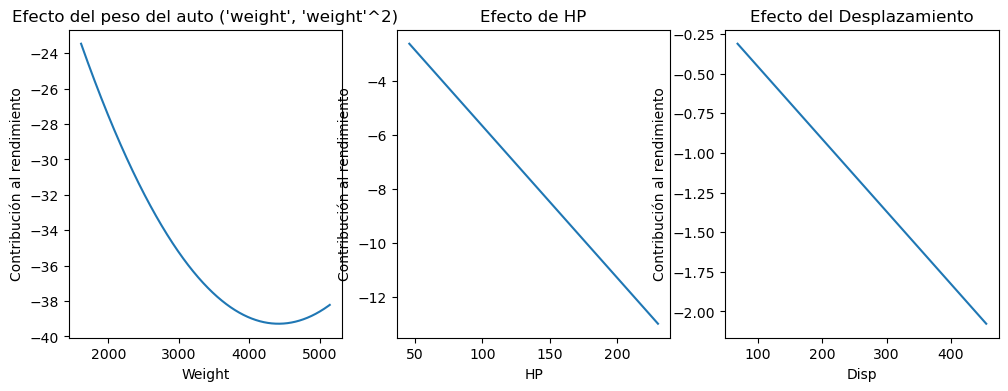

In [24]:
fig = plt.figure(figsize=(12,4))

x_wt = np.arange(dfautos['weight'].min(), dfautos['weight'].max(), 0.01)
wtcoef = fitted_model.params.weight
wt2coef = fitted_model.params.weight_2
y_wt = wtcoef*x_wt + wt2coef*x_wt**2

ax1 = fig.add_subplot(131)
ax1.plot(x_wt, y_wt)
ax1.set_title("Efecto del peso del auto ('weight', 'weight'^2)")
ax1.set_xlabel("Weight")
ax1.set_ylabel("Contribución al rendimiento")

hpcoef = fitted_model.params.horsepower
x_hp = np.arange(dfautos['horsepower'].min(), dfautos['horsepower'].max(), 0.01)
y_hp = hpcoef*x_hp

ax2 = fig.add_subplot(132)
ax2.plot(x_hp, y_hp)
ax2.set_title("Efecto de HP")
ax2.set_xlabel("HP")
ax2.set_ylabel("Contribución al rendimiento")

dispcoef = fitted_model.params.displacement
x_disp = np.arange(dfautos['displacement'].min(), dfautos['displacement'].max(), 0.01)
y_disp = dispcoef*x_disp

ax3=fig.add_subplot(133)
ax3.plot(x_disp, y_disp)
ax3.set_title("Efecto del Desplazamiento")
ax3.set_xlabel("Disp")
ax3.set_ylabel("Contribución al rendimiento")

plt.show()

## 5. Problemas a considerar

### 5.1 Colineares

Cuando tenemos datos que tienen colinearidad entre ellos, podemos tener problemas al aplicar regresiones.

Generating Data


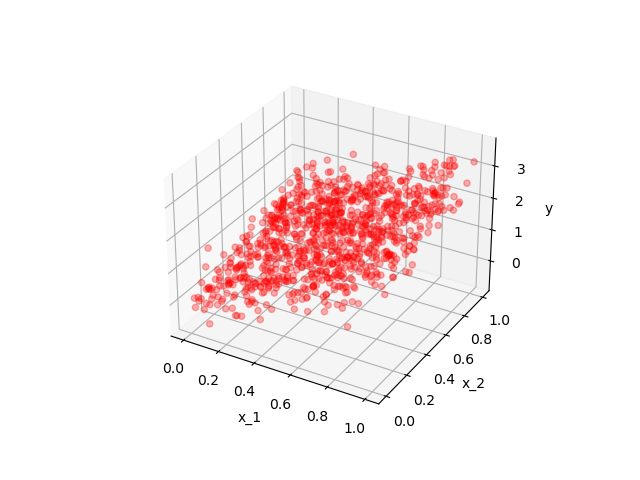

In [25]:
#%% Generate Data
# for creating a responsive plot
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

print('Generating Data')
# sample size
T = 1000
# number of factors
m = 2
# generate factor values
x = rnd.uniform(size=(T,m))

#%% Model
# real world factors
betaR = np.array([[2], [1]])

# noise variance
s = .4
# observed data
y = np.dot(x, betaR) + rnd.normal(0, s, size=(T,1))

fig = plt.figure(1)
ax = fig.add_subplot(projection='3d')
ax.scatter(x[:,0], x[:,1], y, c='r', alpha=0.3)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
plt.show()

Regression Model
Coefficients: [1.94913369 0.93598518]
r2 = 0.690201209188412


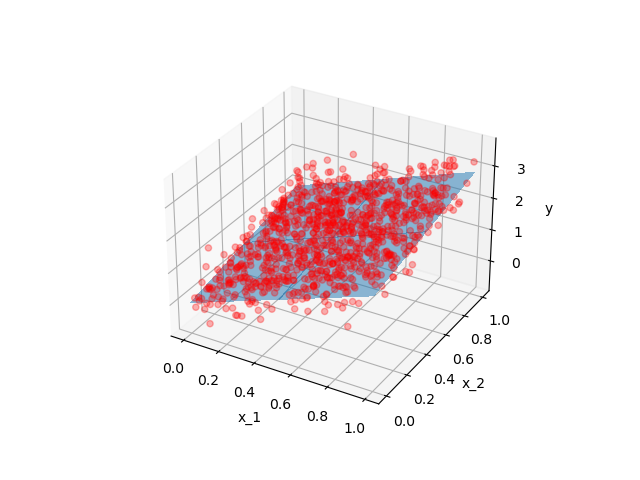

In [26]:
#%% Regression
from sklearn import linear_model

print('Regression Model')
# make linear regression model
regr = linear_model.LinearRegression()

# fit model with data
regr.fit(x, y)
r2 = regr.score(x, y)
# get coefficients and fitness
betaReg = regr.coef_[0]
print('Coefficients: ' + str(betaReg))
print('r2 = ' + str(r2))

# build plane
Xp, Yp = np.meshgrid(np.arange(0, 1.1, .5), np.arange(0, 1.1, .5))
Zp = betaReg[0] * Xp + betaReg[1] * Yp
# plot plane
fig = plt.figure(2)
ax = fig.add_subplot(projection='3d')

ax.plot_surface(Xp, Yp, Zp, linewidth=0, antialiased=False, alpha=0.5)
ax.scatter(x[:,0], x[:,1], y, c='r', alpha=0.3)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
plt.show()

Generating Collinear Data


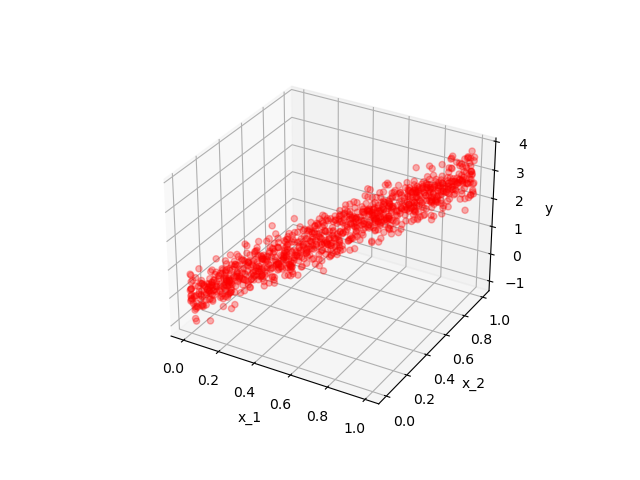

In [27]:
#%% Make collinear data
print('Generating Collinear Data')
# generate factor values
xCol = rnd.uniform(size=(T,m))
xCol[:,1] = xCol[:,0] + rnd.normal(0, .0001, size=T)

# observed data
yCol = np.dot(xCol, betaR) + rnd.normal(0, s, size=(T,1))

fig = plt.figure(3)
ax = fig.add_subplot(projection='3d')

ax.scatter(xCol[:,0], xCol[:,1], yCol, c='r', alpha=0.3)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
plt.show()

In [28]:
#%% Collinear Regression
# make linear regression model
regrCol = linear_model.LinearRegression()
# fit model with data
regrCol.fit(xCol, yCol)
r2Col = regrCol.score(xCol, yCol)
# get coefficients
betaCol = regrCol.coef_[0]
print('Coefficients: ' + str(betaCol))
print('r2 = ' + str(r2Col))

Coefficients: [ 15.13754522 -12.14212154]
r2 = 0.8103315701925001


### La Paradoja de Simpson

Otro elemento clásico a considerar al realizar regresiones.

In [29]:
%matplotlib inline
df = pd.read_csv("berkeley.csv")
df.head()

,Year,Major,Gender,Admission
0,1973,C,F,Rejected
1,1973,B,M,Accepted
2,1973,Other,F,Accepted
3,1973,Other,M,Accepted
4,1973,Other,M,Rejected


In [30]:
gender_group = df.groupby(['Gender', 'Admission']).size().unstack()
gender_group

Admission,Accepted,Rejected
Gender,,
F,1494,2827
M,3738,4704


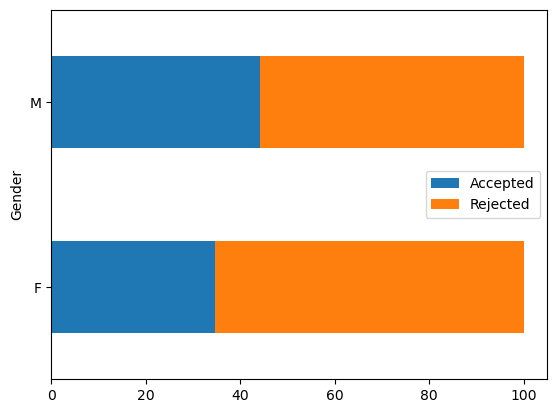

In [32]:
gender_group.apply(lambda x:100*x/x.sum(), axis=1).plot(kind='barh', stacked=True, legend=False)
plt.legend(['Accepted', 'Rejected'])

¿Fue el sistema de admisión de Berkeley sesgado?

In [33]:
gender_group_major = df.groupby(['Major', 'Gender', 'Admission']).size().unstack()
gender_group_major

Admission     Accepted  Rejected
Major Gender                    
A     F             89        19
      M            825       313
B     F             17         8
      M            353       207
C     F            201       392
      M            120       205
D     F            131       244
      M            138       279
E     F             94       299
      M             53       138
F     F             25       316
      M             22       351
Other F            937      1549
      M           2227      3211

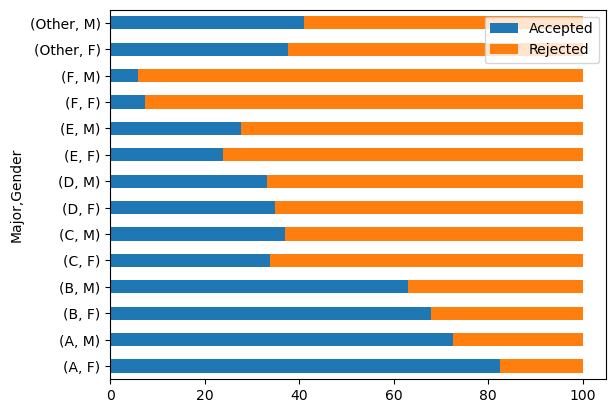

In [34]:
gender_group_major.apply(lambda x:100*x/x.sum(), axis=1).plot(kind='barh', stacked=True, legend=False)
plt.legend(['Accepted', 'Rejected'])

Veamos por qué pasa esto con otro ejemplo

In [35]:
df = pd.read_csv("clientes.csv")
df.head()

,Unnamed: 0,Satisfaction,Time_spent,Country
0,0,1.630830,1.088682,0
1,1,1.778911,0.886501,0
2,2,2.102769,1.440529,0
3,3,1.662359,1.522275,0
4,4,2.311539,1.169235,0


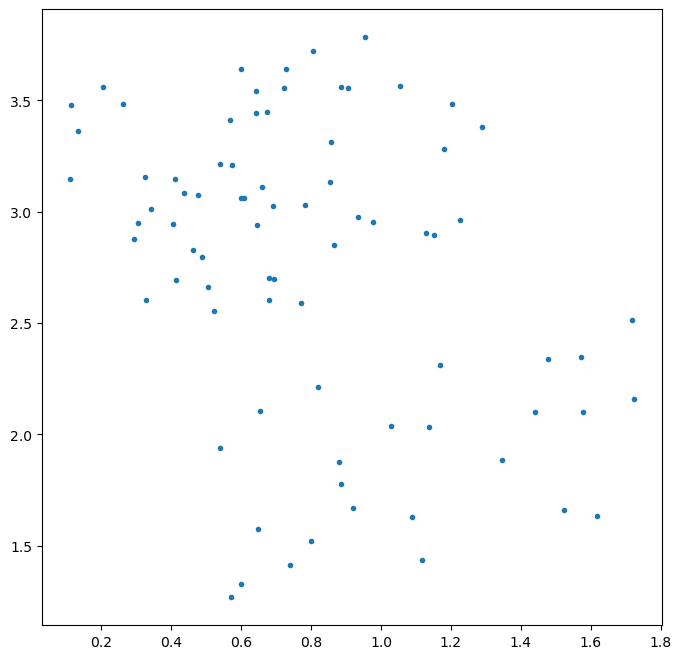

In [36]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(df['Time_spent'], df['Satisfaction'], '.')

In [37]:
import statsmodels.api as sm

regresion = sm.OLS(df["Satisfaction"], sm.add_constant(df["Time_spent"])).fit()
print(regresion.params)

const         3.231512
Time_spent   -0.616098
dtype: float64


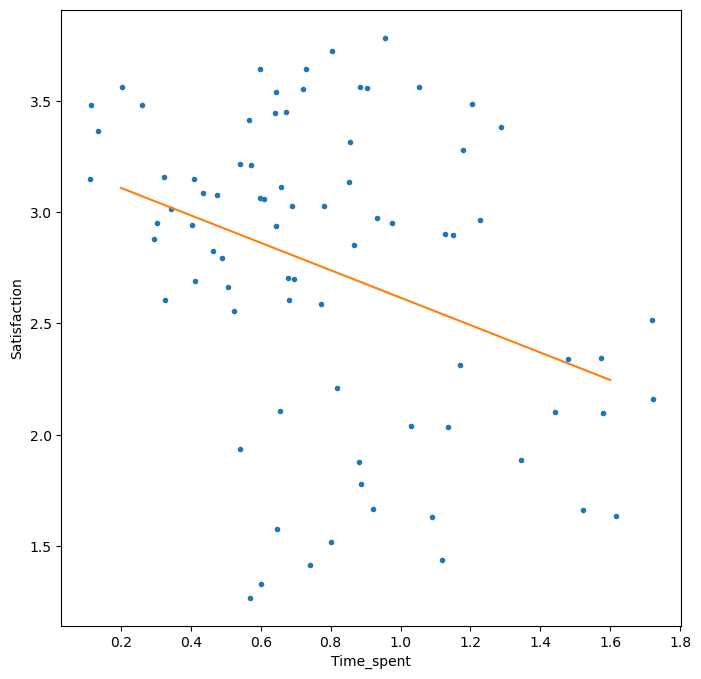

In [38]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(df['Time_spent'], df['Satisfaction'], '.')
plt.xlabel('Time_spent')
plt.ylabel('Satisfaction')
x = np.array([0.2, 1.6])
plt.plot(x, regresion.params.const + regresion.params.Time_spent*x, '-')

Text(0, 0.5, 'Satisfaction')

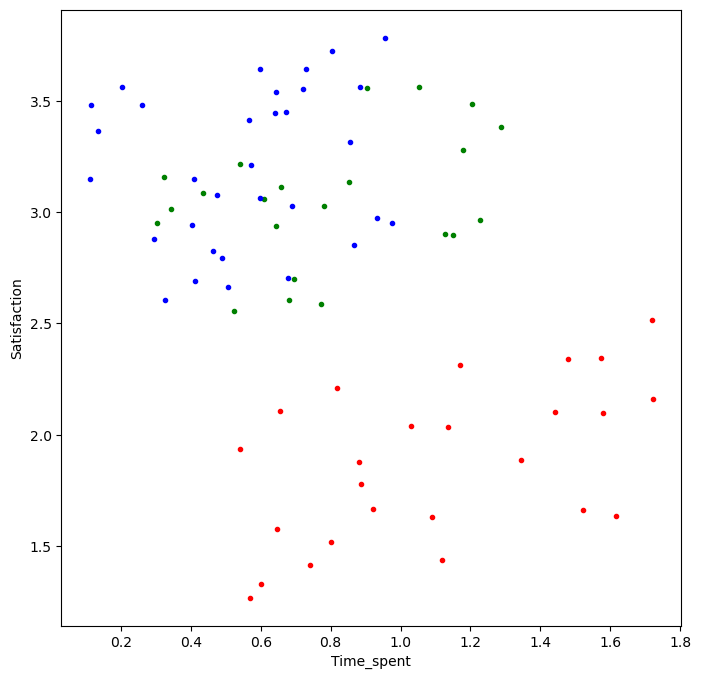

In [39]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(df['Time_spent'][df['Country']==0], df['Satisfaction'][df['Country']==0], 'r.')
plt.plot(df['Time_spent'][df['Country']==1], df['Satisfaction'][df['Country']==1], 'g.')
plt.plot(df['Time_spent'][df['Country']==2], df['Satisfaction'][df['Country']==2], 'b.')
plt.xlabel('Time_spent')
plt.ylabel('Satisfaction')

In [40]:
reg0 = sm.OLS(df["Satisfaction"][df['Country']==0], sm.add_constant(df["Time_spent"][df['Country']==0])).fit()
reg1 = sm.OLS(df["Satisfaction"][df['Country']==1], sm.add_constant(df["Time_spent"][df['Country']==1])).fit()
reg2 = sm.OLS(df["Satisfaction"][df['Country']==2], sm.add_constant(df["Time_spent"][df['Country']==2])).fit()

Text(0, 0.5, 'Satisfaction')

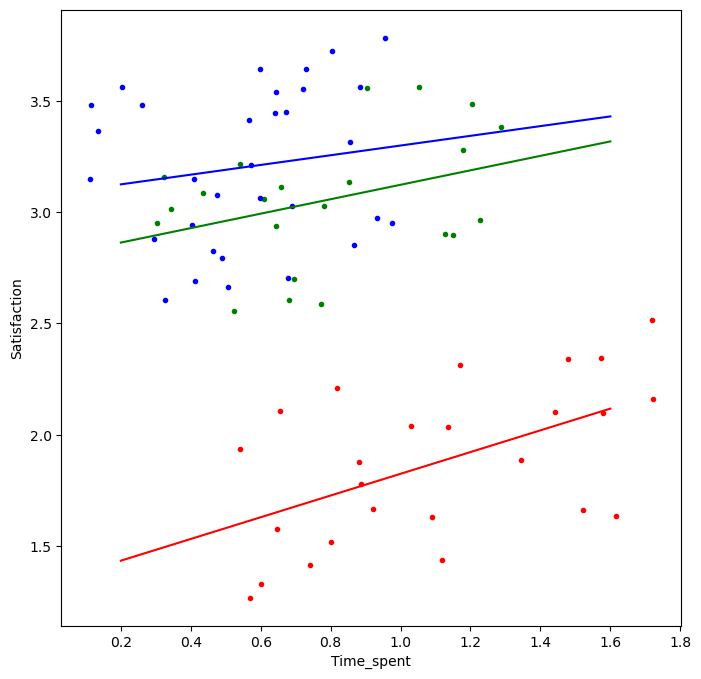

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(df['Time_spent'][df['Country']==0], df['Satisfaction'][df['Country']==0], 'r.')
plt.plot(df['Time_spent'][df['Country']==1], df['Satisfaction'][df['Country']==1], 'g.')
plt.plot(df['Time_spent'][df['Country']==2], df['Satisfaction'][df['Country']==2], 'b.')

x = np.array([0.2, 1.6])
plt.plot(x, reg0.params.const + reg0.params.Time_spent*x, '-r')
plt.plot(x, reg1.params.const + reg1.params.Time_spent*x, '-g')
plt.plot(x, reg2.params.const + reg2.params.Time_spent*x, '-b')
plt.xlabel('Time_spent')
plt.ylabel('Satisfaction')

In [42]:
import statsmodels.formula.api as smf

multi_model = smf.mixedlm("Satisfaction ~ Time_spent", data=df, groups=df["Country"], re_formula="Time_spent").fit()
print(multi_model.fe_params)
print(multi_model.random_effects)

Intercept     2.413656
Time_spent    0.336944
dtype: float64
{0: Group        -1.061013
Time_spent    0.141689
dtype: float64, 1: Group         0.414861
Time_spent   -0.055401
dtype: float64, 2: Group         0.646152
Time_spent   -0.086288
dtype: float64}


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
